In [44]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F
from neural_network_architectures import SeismicCNN_2d

# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

In [4]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

In [5]:
pd.set_option('display.max_columns', None)
cat_all = pd.read_csv('../../data/IRISExoticEventCatalog.txt', sep='|')
cat = cat_all.copy()
cat

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

In [6]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [7]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [8]:
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [9]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in tqdm(range(len(event_ids))):
    try:
        files = glob("../../data/iris_esec_waveforms/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type = 'linear')
            d = tr[0].resample(100).data
            
            ## We are going to test the ml_40 model (so we will use P-10, P+30)
            data = d[8500:12500]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 5:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

100%|██████████| 245/245 [00:52<00:00,  4.69it/s]


In [10]:
data

array([115.12102129, 120.3695389 , 142.87197234, ..., 202.8469757 ,
       173.34259434, 177.34490723])

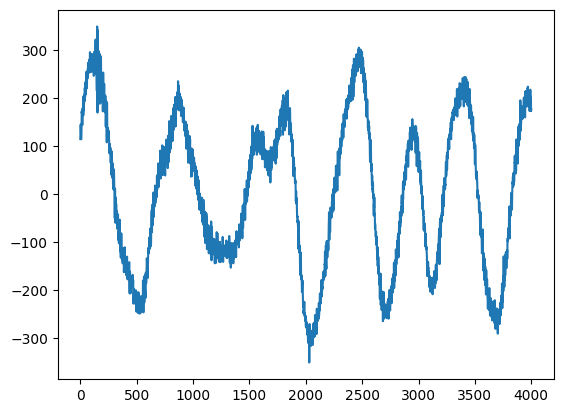

In [11]:
plt.plot(data)

## Loading the trained model

In [14]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = "cuda"



model_quakexnet_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)
model_quakexnet_2d.to(device)
model_quakexnet_2d.eval()


model = model_quakexnet_2d
model.to('cuda')


SeismicCNN_2d(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.9, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## No processing just loading the data here

In [14]:
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
snr_trace_z = []
event_types = []
event_subtypes = []
event_duration = []
trids = []

for i in tqdm(range(len(event_ids))):
    try:
        
        # Find all three-component waveforms for this event
        files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_ids[i]}/*H*")
        
        
        # Dictionary to group traces by station
        station_data = {}

        
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type='linear')
            d = tr[0].resample(50).data
            
            data = d[:13500]  # Extract P-10 to P+30 (assuming 50 Hz sampling)
            snr = np.nanmax(abs(data)) / np.nanmean(abs(data))

            if snr > 1:
                station = tr[0].stats.station
                channel = tr[0].stats.channel
                key = (event_ids[i], station)  # Group by event and station
                
                if key not in station_data:
                    station_data[key] = {}

                station_data[key][channel] = data  # Store by channel

        # Process each station
        for key, traces in station_data.items():
            if len(traces) == 3:  # Ensure three-component data exists
                sorted_channels = sorted(traces.keys())  # Ensure order is consistent
                stacked_data = np.stack([traces[ch] for ch in sorted_channels])  # Shape (3, 4000)

                st_data.append(stacked_data)  # Append in shape (3, 4000)
                evids.append(key[0])  # Event ID
                trids.append(key[1])  # Station ID
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])

    except Exception as e:
        print(f"Error processing event {event_ids[i]}: {e}")
        continue

# Convert to NumPy array
st_data = np.array(st_data)  # Final shape: (num_events, 3, 4000)


 46%|████▌     | 112/245 [00:55<02:20,  1.06s/it]/tmp/ipykernel_3708493/4101181955.py:29: RuntimeWarning: invalid value encountered in double_scalars
  snr = np.nanmax(abs(data)) / np.nanmean(abs(data))
100%|██████████| 245/245 [02:06<00:00,  1.94it/s]


## Computing the results of these waveforms - 

In [ ]:
probs_array = []
taper_alpha = 0.1
lowcut = 1
highcut = 20
nyquist = 0.5 * 50  # Nyquist frequency (original sampling rate is 100 Hz)
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')  # Bandpass filter coefficients
taper_alpha = 0.1
fs = 50







for i in tqdm(range(len(st_data))):
    data = st_data[i]

    # Parameters
    window_size = 5000  # 100s
    stride = 500   # 10s
    num_windows = (data.shape[1] - window_size) // stride + 1  # Compute the number of windows

    # Create windows
    windows = np.stack([data[:, i:i+window_size] for i in range(0, data.shape[1] - window_size + 1, stride)])



    tapered_data = np.array([np.multiply(signal.windows.tukey(windows.shape[-1], alpha=taper_alpha), row) for row in windows])
    filtered_data = np.array([signal.filtfilt(b, a, row) for row in tapered_data])
    norm = np.std(abs(filtered_data), axis=(1,2))
    norm = norm.reshape(-1, 1, 1)
    normalized_data = (filtered_data / norm)
    specs = extract_spectrograms(normalized_data)


    # Run classification
    with torch.no_grad():
        output = model(torch.Tensor(specs).to(device))
        softmax_probs = F.softmax(output, dim=1).cpu().numpy()

    probs_array.append(softmax_probs)


In [21]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")
model2 = sbm.SeismicCNN.from_pretrained("base")

In [25]:
file_sample = glob('../../data/iris_esec_waveforms/waveforms/227/*A291A*')

In [28]:
st = []
for file in file_sample:
    st += obspy.read(file)
    
st = obspy.Stream(st)

In [33]:
arr = np.array(model2.annotate(st))

In [37]:
arr

array([[7.3844111e-01, 6.6509847e-06, 8.5157611e-05, 1.9520448e-05],
       [1.3945255e-01, 4.8533747e-07, 8.7788858e-04, 7.6727645e-08],
       [1.2205659e-01, 9.9999261e-01, 9.9896693e-01, 9.9997282e-01],
       [4.9787475e-05, 2.9052134e-07, 6.9998991e-05, 7.6376718e-06]],
      dtype=float32)

### The below code is going over each event id, extracting a list of unique stations, then going through each station and selecting the one with three components, then classifying them directly using seisbench. 

In [46]:
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*')
    
    # Extract unique station codes
    station_codes = set()
    for f in file_list:
        fname = Path(f).name
        match = re.match(r"[A-Z0-9]+\.(\w+)", fname)
        if match:
            station_codes.add(match.group(1))

    stn_list = sorted(station_codes)
    
    for stn in stn_list:
        chn_list = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*')

        # Continue only if exactly 3 components are found
        if len(chn_list) == 3:
            try:
                st = obspy.Stream()
                for chn in chn_list:
                    st += obspy.read(chn)
                
                # Optional: sort channels to ensure consistent order
                st.sort(['channel'])
                
                # Predict probabilities using model
                probs_windows = np.array(model2.annotate(st))
                
                # Store in dict
                probs_global[(event_id, stn)] = probs_windows

            except Exception as e:
                print(f"Error with event {event_id}, station {stn}: {e}")


100%|██████████| 245/245 [14:43<00:00,  3.61s/it] 


In [81]:
def process_probabilities(probs_dict, threshold=0.5):
    rows = []
    for (event_id, station), prob_array in probs_dict.items():
        
        prob_eq = prob_array[0].max()
        prob_px = prob_array[1].max()
        prob_noise = prob_array[2].max()
        prob_su = prob_array[3].max()

        max_prob = max(prob_eq, prob_px, prob_su)
        if max_prob > threshold:
            if max_prob == prob_eq:
                label = 'eq'
            elif max_prob == prob_px:
                label = 'px'
            else:
                label = 'surface'
        else:
            label = 'noise'

        rows.append({
            'event_id': event_id,
            'station': station,
            'prob_eq': prob_eq,
            'prob_px': prob_px,
            'prob_noise': prob_noise,
            'prob_surface': prob_su,
            'max_prob': max_prob,
            'assigned_label': label
        })

    return pd.DataFrame(rows)


In [85]:
# Example usage:
labels_df = process_probabilities(probs_global)
labels_df.head()

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label
0,74,SLD,0.009431,0.606736,0.999952,0.979550,0.979550,surface
1,130,PLBC,0.002547,0.965852,0.999910,0.022586,0.965852,px
2,130,SKAG,0.000022,0.025717,0.999947,0.972659,0.972659,surface
3,130,YKU2,0.958946,0.068169,0.999905,0.000694,0.958946,eq
4,160,AUSB,0.000771,0.000075,0.999956,0.000327,0.000771,noise


<Axes: >

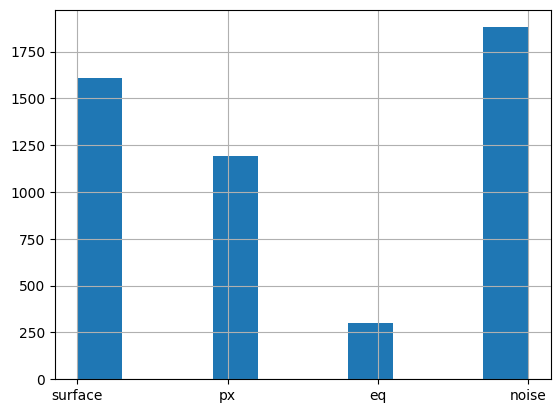

In [86]:
labels_df['assigned_label'].hist()

In [88]:
labels_df.to_csv('../seisbench_output/esec_event_output_labels.csv')

## Observing the waveforms, defining a suitable SNR criteria to filter highly noisy waveforms

In [182]:
def plot_trace(tr):
    # Assuming `tr` is your ObsPy Trace object
    data = tr[0].data  # Amplitude values
    npts = tr[0].stats.npts  # Number of samples
    sampling_rate = tr[0].stats.sampling_rate  # Samples per second

    # Create time axis in seconds
    time = np.linspace(0, npts / sampling_rate, npts)

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(time, data, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"{tr[0].stats.station}.{tr[0].stats.channel} | {tr[0].stats.starttime}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    
    
snr = []
for i in tqdm(range(len(labels_df))):
#for i in tqdm(range(100, 150)):    
    label = labels_df['assigned_label'].values[i]
    event_id = labels_df['event_id'].values[i]
    station = labels_df['station'].values[i]
    files = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{station}*HN*')
    tr = obspy.read(files[0])
    tr.resample(50)
    tr.detrend('linear')
    tr.taper(0.05)
    tr.filter('bandpass', freqmin = 1, freqmax = 20)

    #plot_trace(tr)
    #print(label)
    # snr - signal to noise ratio
    d = tr[0].data
    
    #snr = np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2)))
    #print(snr)
    
    snr.append(np.max(abs(d[3000:8000]))/np.sqrt(np.mean(abs(d[1000:2000])**(2))))
    
labels_df['snr_n'] = snr

100%|██████████| 4986/4986 [00:56<00:00, 87.63it/s] 


## Visualizing the distribution of SNR for each class

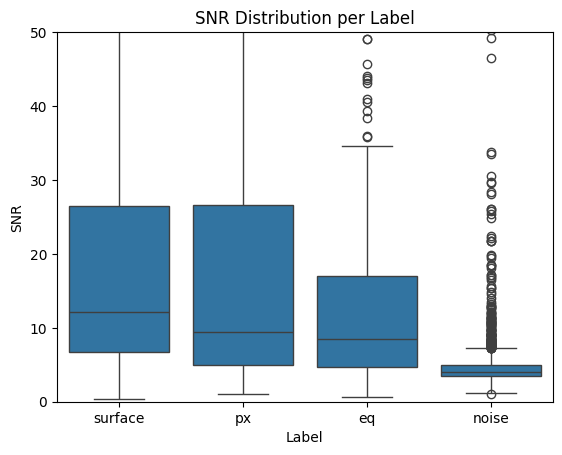

In [176]:
sns.boxplot(data=labels_df, x="assigned_label", y="snr_n")
plt.title("SNR Distribution per Label")
plt.ylim(0,50)
plt.ylabel("SNR")
plt.xlabel("Label")
plt.show()


/tmp/ipykernel_3708493/1748365656.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=filtered, x='assigned_label', palette='pastel', order=filtered['assigned_label'].value_counts().index)


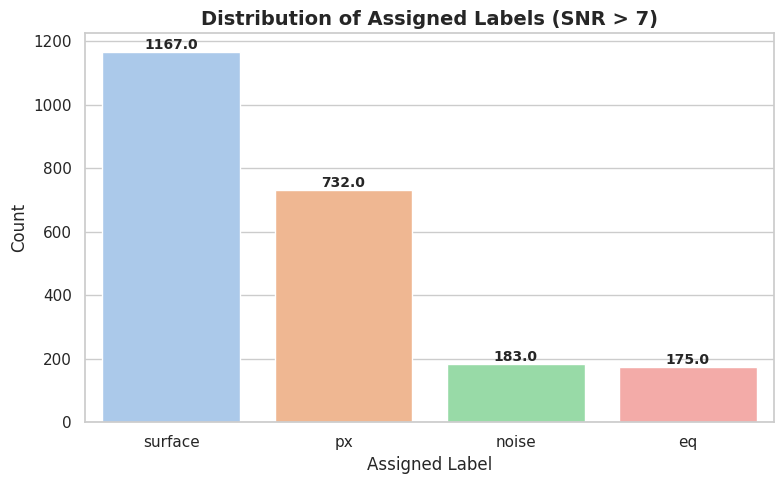

In [183]:
# Set style
sns.set(style="whitegrid")

# Filter and plot
filtered = labels_df[labels_df['snr_n'] > 7]
plt.figure(figsize=(8, 5))
ax = sns.countplot(data=filtered, x='assigned_label', palette='pastel', order=filtered['assigned_label'].value_counts().index)

# Add value labels on top of bars
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Titles and labels
plt.title("Distribution of Assigned Labels (SNR > 7)", fontsize=14, weight='bold')
plt.xlabel("Assigned Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
